In [1]:
import csv
import os

from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy.stats import norm
import seaborn as sns
import simdna
from simdna import synthetic
import statsmodels.api as sm
import torch
from tqdm.auto import tqdm, trange

from utils import one_hot_decode
from in_silico_mutagenesis import compute_summary_statistics, generate_wt_mut_batches, write_results
from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency
from tf_coop_simulation import simulate_counts, simulate_oracle_predictions

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/stephen/anaconda3/envs/deepmr/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
np.random.seed(42)

# Initialize Model & Load Weights
This step assumes we've trained a counts regression model and have its weights stored in a .pt[h] file somewhere accessible.

In [4]:
n_conv_layers = 3
n_dense_layers = 3
n_outputs = 2
sequence_length = 100
filters = 15
filter_width = 7
dense_layer_width = 30

data_dir = '../dat/sim'
weights_dir = os.path.join(data_dir, 'ensemble')
weights_fname = 'cnn_counts_predictor_with_variants.pt'
test_data_fpath = os.path.join(data_dir, 'test_labels.csv')
raw_simulation_data_fpath = os.path.join(data_dir, 'test_sequences.simdata')
mutagenesis_results_dir = os.path.join(data_dir, 'res')

os.makedirs(mutagenesis_results_dir, exist_ok=True)

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000
n_samples = 10

includes_confounder = False
exposure_motif = "GATA_disc1"
outcome_motif = "TAL1_known1"
confounder_motif = "SOX2_1" if includes_confounder else None

In [5]:
torch.set_grad_enabled(False)

In [7]:
class Ensemble:
    def __init__(self, model_base_dir, model_fname, model_params, n_reps=5):
        models = []
        for i in range(1, n_reps+1):
            model = CountsRegressor(**params)
            model.load_state_dict(torch.load(os.path.join(model_base_dir, str(i), model_fname)))
            models.append(model)
        self.models = models

    def predict(self, seqs, targets=None):
        preds = {}
        for model in self.models:
            model_preds = model(seqs, targets=targets)
            for key, preds_ in model_preds.items():
                preds.setdefault(key, []).append(preds_.detach().cpu().numpy())
        return {k: np.stack(v) for k, v in preds.items()}

# class CalibratedRegressionEnsemble
#     def __init__(self, base_model, calibration_data_loader):
#         self._base_model= base_model
#         self._lambdas = self._compute_lambdas(base_model, calibration_data_loader)
    
#     @classmethod
#     def _compute_lambdas(cls, model, data_loader):
#         predictions = []
#         true_vals = []
#         mses = []
#         for (x, y) in test_data_loader:
#             assert len(x) == len(y) == 1
#             p = ensemble_model.predict(x, targets=y)['predictions']
#             predictions.append(p)
#             true_vals.append(y.numpy())
#             mses.append(np.sqrt((y.numpy() - np.mean(p)) ** 2))
#         pred_means = np.mean(predictions, axis=1).squeeze()
#         pred_vars = np.var(predictions, axis=1).squeeze()
#         lambdas = (1 / len(pred_ses)) * np.sum((1 / pred_vars) * (np.array(true_vals) - pred_means) ** 2, axis=0)
#         return lambdas

#     def predict(self, seqs, targets=None):
#         preds = self._base_model.predict(seqs, targets=targets)
#         preds['mean'] = np.mean(preds['predictions'], )
#         mean = np.mean(preds, )

In [8]:
params = {
    "n_conv_layers": n_conv_layers,
    "n_dense_layers": n_dense_layers,
    "n_outputs": n_outputs,
    "sequence_length": sequence_length,
    "filters": filters,
    "filter_width": filter_width,
    "dense_layer_width": dense_layer_width
}
ensemble_model = Ensemble(weights_dir, "cnn_counts_predictor.pt", params, n_reps=5)
ensemble_model

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs.

In [9]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
    y_transform=anscombe_transform
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=0
)

# Recalibration

In [27]:
predictions = []
true_vals = []
mses = []
for (x, y) in test_data_loader:
    p = ensemble_model.predict(x, targets=y)['predictions']
    predictions.append(p)
    true_vals.append(y.numpy())
    mses.append((y.numpy() - np.mean(p.squeeze(), axis=0)) ** 2)

pred_means = np.mean(predictions, axis=1).squeeze()
pred_vars = np.var(predictions, axis=1).squeeze()
true_vals = np.array(true_vals).squeeze()
predictions = np.array(predictions).squeeze()

In [28]:
print(predictions.shape, pred_means.shape)

(10000, 5, 2) (10000, 2)


In [11]:
y_mean_stds = zip(np.array(true_vals).squeeze(), pred_means, np.sqrt(pred_vars))
estimated_cum_probs = np.array(
    [norm.cdf(y, loc=mean, scale=std) for (y, mean, std) in y_mean_stds]
)
cum_probs = np.zeros_like(estimated_cum_probs)
for f in [0, 1]:
    for i in range(len(estimated_cum_probs)):
        ecpf = estimated_cum_probs[:, f]
        p_hat = len(ecpf[ecpf <= ecpf[i]]) / float(len(ecpf))
        cum_probs[i, f] = p_hat

Feature 0
Before Recalibration
   MACE: 0.40465, RMSCE: 0.45873, MA: 0.40873


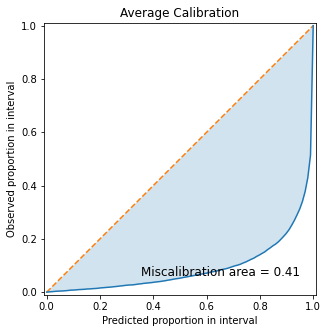

 After Recalibration
   MACE: 0.07186, RMSCE: 0.11447, MA: 0.07257


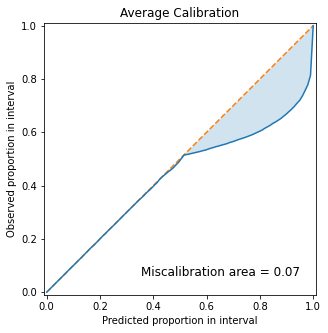

Feature 1
Before Recalibration
   MACE: 0.44111, RMSCE: 0.50423, MA: 0.44557


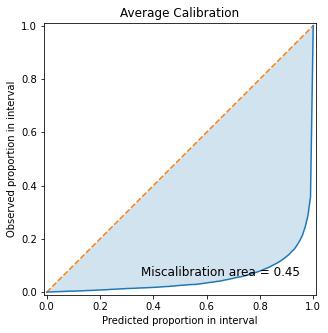

 After Recalibration
   MACE: 0.15050, RMSCE: 0.21308, MA: 0.15202


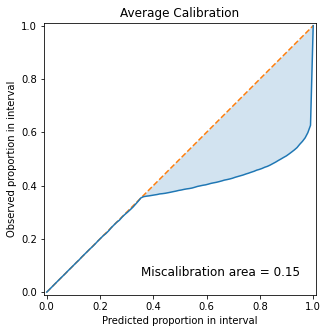

In [31]:
import uncertainty_toolbox.data as udata
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

recal_models = []
for f in [0, 1]:
    y = true_vals[:, f]
    pred_mean, pred_std = pred_means[:, f], np.sqrt(pred_vars)[:, f]
    # Before recalibration
    exp_props, obs_props = get_proportion_lists_vectorized(pred_mean, pred_std, true_vals[:, f])
    recal_model = None
    mace = umetrics.mean_absolute_calibration_error(
        pred_mean, pred_std, y, recal_model=recal_model
    )
    rmsce = umetrics.root_mean_squared_calibration_error(
        pred_mean, pred_std, y, recal_model=recal_model
    )
    ma = umetrics.miscalibration_area(
        pred_mean, pred_std, y, recal_model=recal_model
    )
    print(f"Feature {f}")
    print("Before Recalibration")
    print("   MACE: {:.5f}, RMSCE: {:.5f}, MA: {:.5f}".format(mace, rmsce, ma))

    uviz.plot_calibration(
        pred_mean,
        pred_std,
        y,
        exp_props=exp_props,
        obs_props=obs_props,
        show=True,
    )

    # After recalibration
    recal_model = iso_recal(exp_props, obs_props)
    recal_models.append(recal_model)
    recal_exp_props, recal_obs_props = get_proportion_lists_vectorized(
        pred_mean, pred_std, y, recal_model=recal_model
    )
    mace = umetrics.mean_absolute_calibration_error(
        pred_mean, pred_std, y, recal_model=recal_model
    )
    rmsce = umetrics.root_mean_squared_calibration_error(
        pred_mean, pred_std, y, recal_model=recal_model
    )
    ma = umetrics.miscalibration_area(
        pred_mean, pred_std, y, recal_model=recal_model
    )
    print(" After Recalibration")
    print("   MACE: {:.5f}, RMSCE: {:.5f}, MA: {:.5f}".format(mace, rmsce, ma))

    uviz.plot_calibration(
        pred_mean,
        pred_std,
        y,
        exp_props=recal_exp_props,
        obs_props=recal_obs_props,
        show=True
    )

In [32]:
recal_model.predict([.16, .84])

array([0.92746615, 0.99748496])